# Evaluation of bandit algorithm in a non-stationary setting

Figure 7 in the paper.

In [1]:
import collections
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pickle

from scipy.stats import entropy

from impatient_bandits import (
    BayesianBandit,
    ProgressiveBelief,
    DelayedBelief,
    OracleBelief,
    DayTwoBelief,
    EmpiricalDistribution,
    Environment,
    StickinessHelper,
)

In [2]:
# Simulation parameters
n_shows = 400
window = 60
horizon = n_shows - window
n_actions = 50
n_trials = 10

rng = np.random.default_rng(seed=0)

In [3]:
# Training set.
with open("data/synthetic-data-train.pkl", "rb") as f:
    raw = pickle.load(f)

data_train = {k: v.astype(float) for k, v in raw.items()}
helper = StickinessHelper.from_data(data_train)

# Evaluation set.
with open("data/synthetic-data-eval.pkl", "rb") as f:
    raw = pickle.load(f)

data_eval = {k: v.astype(float) for k, v in itertools.islice(raw.items(), n_shows)}

dists = {uri: EmpiricalDistribution(traces) for uri, traces in data_eval.items()}
env = Environment(dists)

In [4]:
def bandit_trial(
    env,
    beliefs,
    horizon,
    n_actions,
    rng,
):
    agent = BayesianBandit(beliefs)
    shows = np.array(list(beliefs.keys()))[rng.permutation(len(beliefs))]
    regrets = list()
    for t in range(horizon):
        admissible = shows[t : t + window]
        r_optimal = max(env.dists[uri].mean_sum for uri in admissible)
        # Pick a number of actions.
        actions = agent.act(n_actions, admissible=admissible)
        for i, action in enumerate(actions):
            # `step` returns a-vector of activities and number of users.
            trace = env.step(action, t)
            # Update the bandit's reward models based on observed outcome
            agent.update(action, trace)
        agent.step()
        true_rewards = np.array([env.dists[action].mean_sum for action in actions])
        regrets.append(np.mean(r_optimal - true_rewards))
    return np.array(regrets)

In [5]:
%%time

belief_classes = (
    ("Progressive", ProgressiveBelief),
    ("Delayed", DelayedBelief),
    ("Day-two proxy", DayTwoBelief),
    ("Oracle", OracleBelief),
)

reg = dict()

for name, cls in belief_classes:
    reg[name] = np.zeros((n_trials, horizon))
    for k in range(n_trials):
        print(".", end="", flush=True)
        env.reset()
        # Initialise stickiness beliefs per show
        beliefs = dict()
        for idx, uri in enumerate(data_eval):
            beliefs[uri] = cls(
                prior_mvec=helper.prior_mvec,
                prior_cmat=helper.prior_cmat,
                noise_cmat=helper.noise_cmat,
                cov_estimator="fixed",
                seed=rng,
            )
        # Evaluate algorithm
        reg[name][k] = bandit_trial(
            env,
            beliefs,
            horizon,
            n_actions,
            rng,
        )
    print()

..........
..........
..........
..........
CPU times: user 10min 6s, sys: 26.3 s, total: 10min 33s
Wall time: 3min 22s


Text(0.5, 0, 'Days')

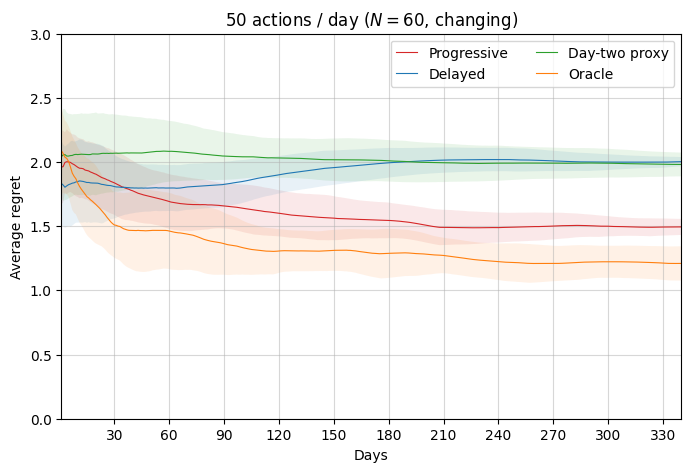

In [6]:
fig, ax = plt.subplots(figsize=(8, 5))
xs = np.arange(1, horizon + 1)

color = {
    "Progressive": plt.cm.tab10(3),
    "Delayed": plt.cm.tab10(0),
    "Day-two proxy": plt.cm.tab10(2),
    "Oracle": plt.cm.tab10(1),
}
linestyle = {
    "Progressive": "-",
    "Delayed": "--",
    "Day-two proxy": "--",
    "Oracle": "--",
}

for name, regrets in reg.items():
    # Average regret.
    areg = np.cumsum(regrets, axis=1) / xs
    mean = np.mean(areg, axis=0)
    std = np.std(areg, axis=0)
    ax.plot(xs, mean, lw=0.8, ls="-", color=color[name], label=name)
    ax.fill_between(xs, mean - std, mean + std, facecolor=color[name], alpha=0.1)
    ax.set_ylim(ymin=0, ymax=3)
    ax.grid(lw=0.8, alpha=0.5)

ax.set_title(f"{n_actions} actions / day ($N = {window}$, changing)")
ax.legend(frameon=True, ncol=2, handlelength=1.5)
ax.set_xlim(xmin=1, xmax=horizon)
ax.set_xticks(np.arange(30, horizon + 1, step=30))
ax.set_ylabel("Average regret")
ax.set_xlabel("Days")